In [59]:
# Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import tensorflow as tf
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM, Dropout, GRU
from keras.callbacks import History 

# Read Data

In [2]:
real = pd.read_csv("True.csv")
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [3]:
fake = pd.read_csv("Fake.csv")
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
# Create Target based on Real and Fake data
real['Category'] = 1
fake['Category'] = 0

In [5]:
print(real.shape)
real.head()

(21417, 5)


,title,text,subject,date,Category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [6]:
print(fake.shape)
fake.head()

(23481, 5)


,title,text,subject,date,Category
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [7]:
dataset = pd.concat([real, fake]).reset_index(drop=True)

In [8]:
print(dataset.shape)
dataset.head()

(44898, 5)


,title,text,subject,date,Category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


# Data Analysis

In [9]:
dataset['final_text'] = dataset['title'] + dataset['text']
dataset['final_text'].head()

0    As U.S. budget fight looms, Republicans flip t...
1    U.S. military to accept transgender recruits o...
2    Senior U.S. Republican senator: 'Let Mr. Muell...
3    FBI Russia probe helped by Australian diplomat...
4    Trump wants Postal Service to charge 'much mor...
Name: final_text, dtype: object

In [10]:
dataset['Category'].value_counts()

0    23481
1    21417
Name: Category, dtype: int64

In [11]:
dataset[['Category','subject','final_text']].groupby(['Category','subject']).count()

final_text
Category subject                    
0        Government News        1570
         Middle-east             778
         News                   9050
         US_News                 783
         left-news              4459
         politics               6841
1        politicsNews          11272
         worldnews             10145

# Data Cleaning

#### Preprocessing Text to get Stemmed and Lemmatized Corpus

In [12]:
porter_stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [13]:
# nltk.download('all')

In [14]:
stemmed_text = []
lemmatized_text = []
final_text_result = []
for text in dataset['final_text']:
    result = re.sub('[^a-zA-Z]', ' ', text)
    result = result.lower()
    result = result.split()
    result = [r for r in result if r not in set(stopwords.words('english'))]
    final_text_result.append(" ".join(result))
    stemmed_result = [porter_stemmer.stem(r) for r in result]
    stemmed_text.append(" ".join(stemmed_result))
    lemmatized_result = [lemmatizer.lemmatize(r) for r in result]
    lemmatized_text.append(" ".join(lemmatized_result))

In [15]:
print(len(final_text_result))
print(len(stemmed_text))
print(len(lemmatized_text))

44898
44898
44898


# Create models using CountVectorizer and TFIDF Vectorizer

In [16]:
def get_prediction(vectorizer, classifier, X_train, X_test, y_train, y_test):
    pipe = Pipeline([('vector', vectorizer),
                    ('model', classifier)])
    model = pipe.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Accuarcy: {}".format(round(accuracy_score(y_test, y_pred)*100,2)))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix: \n", cm)
    print("Classification Report: \n", classification_report(y_test, y_pred))

In [17]:
print("******USING STEMMED TEXT********")
X_train, X_test, y_train, y_test = train_test_split(stemmed_text, dataset['Category'], test_size = 0.3, random_state= 0)
classifiers = [LogisticRegression(), SGDClassifier(), MultinomialNB(), BernoulliNB(), LinearSVC(),
              KNeighborsClassifier(n_neighbors=5), DecisionTreeClassifier(), GradientBoostingClassifier(), 
               RandomForestClassifier(), XGBClassifier()]
for classifier in classifiers:
    print("\n\n", classifier)
    print("***********Usng Count Vectorizer****************")
    get_prediction(CountVectorizer(), classifier, X_train, X_test, y_train, y_test)
    print("***********Usng TFIDF Vectorizer****************")
    get_prediction(TfidfVectorizer(), classifier, X_train, X_test, y_train, y_test)

******USING STEMMED TEXT********


 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
***********Usng Count Vectorizer****************


C:\Users\charu\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuarcy: 99.63
Confusion Matrix: 
 [[7043   26]
 [  24 6377]]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7069
           1       1.00      1.00      1.00      6401

    accuracy                           1.00     13470
   macro avg       1.00      1.00      1.00     13470
weighted avg       1.00      1.00      1.00     13470

***********Usng TFIDF Vectorizer****************
Accuarcy: 98.66
Confusion Matrix: 
 [[6963  106]
 [  74 6327]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      7069
           1       0.98      0.99      0.99      6401

    accuracy                           0.99     13470
   macro avg       0.99      0.99      0.99     13470
weighted avg       0.99      0.99      0.99     13470



 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.

C:\Users\charu\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuarcy: 99.52
Confusion Matrix: 
 [[7035   34]
 [  31 6370]]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7069
           1       0.99      1.00      0.99      6401

    accuracy                           1.00     13470
   macro avg       1.00      1.00      1.00     13470
weighted avg       1.00      1.00      1.00     13470

***********Usng TFIDF Vectorizer****************
Accuarcy: 99.47
Confusion Matrix: 
 [[7031   38]
 [  33 6368]]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      7069
           1       0.99      0.99      0.99      6401

    accuracy                           0.99     13470
   macro avg       0.99      0.99      0.99     13470
weighted avg       0.99      0.99      0.99     13470



 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jo

In [18]:
print("******USING LEMMATIZED TEXT********")
X_train, X_test, y_train, y_test = train_test_split(lemmatized_text, dataset['Category'], test_size = 0.3, random_state= 0)
classifiers = [LogisticRegression(), SGDClassifier(), MultinomialNB(), BernoulliNB(), LinearSVC(),
              KNeighborsClassifier(n_neighbors=5), DecisionTreeClassifier(), GradientBoostingClassifier(), 
               RandomForestClassifier(), XGBClassifier()]
for classifier in classifiers:
    print("\n\n", classifier)
    print("***********Usng Count Vectorizer****************")
    get_prediction(CountVectorizer(), classifier, X_train, X_test, y_train, y_test)
    print("***********Usng TFIDF Vectorizer****************")
    get_prediction(TfidfVectorizer(), classifier, X_train, X_test, y_train, y_test)

******USING LEMMATIZED TEXT********


 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
***********Usng Count Vectorizer****************


C:\Users\charu\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuarcy: 99.65
Confusion Matrix: 
 [[7046   23]
 [  24 6377]]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7069
           1       1.00      1.00      1.00      6401

    accuracy                           1.00     13470
   macro avg       1.00      1.00      1.00     13470
weighted avg       1.00      1.00      1.00     13470

***********Usng TFIDF Vectorizer****************
Accuarcy: 98.73
Confusion Matrix: 
 [[6966  103]
 [  68 6333]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      7069
           1       0.98      0.99      0.99      6401

    accuracy                           0.99     13470
   macro avg       0.99      0.99      0.99     13470
weighted avg       0.99      0.99      0.99     13470



 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.

C:\Users\charu\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuarcy: 99.6
Confusion Matrix: 
 [[7043   26]
 [  28 6373]]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7069
           1       1.00      1.00      1.00      6401

    accuracy                           1.00     13470
   macro avg       1.00      1.00      1.00     13470
weighted avg       1.00      1.00      1.00     13470

***********Usng TFIDF Vectorizer****************
Accuarcy: 99.53
Confusion Matrix: 
 [[7034   35]
 [  28 6373]]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7069
           1       0.99      1.00      1.00      6401

    accuracy                           1.00     13470
   macro avg       1.00      1.00      1.00     13470
weighted avg       1.00      1.00      1.00     13470



 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_job

##### Here we see that the Decision Tree is giving best with lemmatized texts with accuracy score of 99.66%

# Using LSTM

In [19]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [20]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping

#### Using One hot representation using Stemmed Text

In [21]:
voc_size = 5000
onehot_stemmed_text = [one_hot(word, voc_size) for word in stemmed_text]
print(len(onehot_stemmed_text))
onehot_stemmed_text[0]

44898


[2343,
 3844,
 2349,
 4386,
 277,
 636,
 4935,
 1123,
 3449,
 716,
 2624,
 277,
 3426,
 2343,
 3300,
 3535,
 4799,
 1772,
 1123,
 1517,
 1677,
 4631,
 1293,
 523,
 2228,
 4935,
 2624,
 3301,
 4019,
 3844,
 333,
 2343,
 3913,
 4976,
 4847,
 4622,
 277,
 2343,
 2218,
 1926,
 3360,
 4236,
 3381,
 2460,
 1517,
 1408,
 4366,
 1332,
 1354,
 1030,
 3216,
 1057,
 1101,
 2773,
 3865,
 553,
 4870,
 3216,
 1979,
 4624,
 656,
 1354,
 3844,
 2349,
 4486,
 2352,
 1502,
 3271,
 3889,
 3062,
 4992,
 935,
 1346,
 292,
 535,
 277,
 2749,
 2343,
 912,
 3300,
 3916,
 4239,
 1703,
 277,
 2447,
 845,
 3844,
 3063,
 1898,
 1030,
 3098,
 4075,
 2447,
 4866,
 3063,
 1966,
 521,
 4012,
 1030,
 2628,
 1249,
 565,
 4995,
 4829,
 4633,
 4671,
 4220,
 4662,
 1898,
 1703,
 2785,
 3684,
 2547,
 293,
 1457,
 3063,
 1966,
 521,
 4012,
 1030,
 2450,
 3360,
 4303,
 45,
 2573,
 4782,
 4081,
 3166,
 1340,
 2628,
 3098,
 293,
 1096,
 4320,
 2612,
 2746,
 4631,
 3521,
 2450,
 4935,
 2624,
 425,
 2394,
 418,
 3674,
 1741,
 11

In [22]:
sent_length = 400
embedded_text = pad_sequences(onehot_stemmed_text, padding='pre', maxlen=sent_length)
print(embedded_text)

[[1332 1354 1030 ...   83 3535 3827]
 [   0    0    0 ... 2810 3715 1512]
 [   0    0    0 ... 2284  280 1340]
 ...
 [ 661 4018  102 ... 3502 4695  428]
 [   0    0    0 ... 3502 4287 1014]
 [3517  170 1878 ... 3502  303  428]]


In [23]:
embedding_vector_features = 600
model1 = Sequential()
model1.add(Embedding(voc_size, embedding_vector_features, input_length=sent_length))
model1.add(LSTM(100))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 400, 600)          3000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               280400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 3,280,501
Trainable params: 3,280,501
Non-trainable params: 0
_________________________________________________________________


In [24]:
X_final = np.array(embedded_text)
y_final = dataset['Category']

In [25]:
X_final.shape,y_final.shape

((44898, 400), (44898,))

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.3, random_state = 0)

In [27]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, mode='auto')

In [28]:
model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size = 256, callbacks=([reduce_lr, early_stop]))

C:\Users\charu\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 31428 samples, validate on 13470 samples
Epoch 1/20
31428/31428 [==============================] - 82s 3ms/step - loss: 0.1587 - accuracy: 0.9457 - val_loss: 0.0603 - val_accuracy: 0.9831
Epoch 2/20
31428/31428 [==============================] - 81s 3ms/step - loss: 0.0930 - accuracy: 0.9694 - val_loss: 0.0723 - val_accuracy: 0.9737
Epoch 3/20
31428/31428 [==============================] - 212s 7ms/step - loss: 0.0533 - accuracy: 0.9820 - val_loss: 0.0699 - val_accuracy: 0.9805
Epoch 4/20
31428/31428 [==============================] - 68s 2ms/step - loss: 0.0612 - accuracy: 0.9801 - val_loss: 0.0534 - val_accuracy: 0.9859
Epoch 5/20
31428/31428 [==============================] - 81s 3ms/step - loss: 0.0288 - accuracy: 0.9905 - val_loss: 0.0421 - val_accuracy: 0.9875
Epoch 6/20
31428/31428 [==============================] - 83s 3ms/step - loss: 0.0622 - accuracy: 0.9786 - val_loss: 0.0880 - val_accuracy: 0.9754
Epoch 7/20
31428/31428 [==============================] - 86s 3ms/s

#### Evaluate model

In [29]:
y_pred = model1.predict_classes(X_test)
print("Accuarcy: {}".format(round(accuracy_score(y_test, y_pred)*100,2)))

Accuarcy: 96.64


In [30]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: \n", cm)

Confusion Matrix: 
 [[6884  185]
 [ 267 6134]]


In [31]:
print("Classification Report: \n", classification_report(y_test, y_pred))

Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.97      0.97      7069
           1       0.97      0.96      0.96      6401

    accuracy                           0.97     13470
   macro avg       0.97      0.97      0.97     13470
weighted avg       0.97      0.97      0.97     13470



#### Using One hot representation using Lemmatized Text

In [32]:
voc_size = 5000
onehot_lemmatized_text = [one_hot(word, voc_size) for word in lemmatized_text]
print(len(onehot_lemmatized_text))
onehot_lemmatized_text[0]

44898


[2343,
 3844,
 2349,
 4386,
 277,
 636,
 4935,
 1123,
 3647,
 716,
 464,
 277,
 3426,
 2343,
 3300,
 2007,
 4799,
 1772,
 1586,
 881,
 1677,
 4631,
 1293,
 523,
 683,
 4935,
 464,
 3301,
 2133,
 3844,
 333,
 717,
 3913,
 4976,
 4847,
 4622,
 277,
 2343,
 4282,
 1926,
 3360,
 4015,
 1138,
 2460,
 1517,
 1408,
 4366,
 1332,
 4915,
 3691,
 4399,
 2952,
 1946,
 1812,
 3865,
 553,
 4870,
 4399,
 1979,
 657,
 2308,
 4915,
 3844,
 2349,
 3410,
 323,
 2461,
 4049,
 4235,
 3062,
 4065,
 3979,
 669,
 292,
 535,
 277,
 2749,
 2343,
 912,
 3300,
 603,
 4239,
 1703,
 277,
 2447,
 845,
 3844,
 3016,
 1416,
 3691,
 3098,
 4075,
 2447,
 229,
 3016,
 1966,
 427,
 4220,
 3691,
 2628,
 1249,
 2244,
 1956,
 4829,
 1289,
 4671,
 4220,
 171,
 2454,
 1703,
 2242,
 4364,
 4984,
 293,
 1245,
 3016,
 1966,
 427,
 4220,
 3691,
 2450,
 3360,
 4303,
 45,
 1240,
 1192,
 4081,
 4037,
 1340,
 2628,
 3098,
 4460,
 1096,
 4320,
 2612,
 1570,
 4631,
 1582,
 2450,
 4935,
 464,
 425,
 1516,
 163,
 3674,
 2147,
 1149,
 134

In [33]:
sent_length = 400
embedded_text = pad_sequences(onehot_lemmatized_text, padding='pre', maxlen=sent_length)
print(embedded_text)

[[1332 4915 3691 ...   83 2007 3827]
 [   0    0    0 ... 1655 3715 3325]
 [   0    0    0 ... 2343 3093 1340]
 ...
 [ 661 4018  102 ... 3502 4695  428]
 [   0    0    0 ... 3502 4287 1014]
 [3806  170 1878 ... 3502  303  428]]


In [34]:
embedding_vector_features = 600
model2 = Sequential()
model2.add(Embedding(voc_size, embedding_vector_features, input_length=sent_length))
model2.add(LSTM(100))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 400, 600)          3000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               280400    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 3,280,501
Trainable params: 3,280,501
Non-trainable params: 0
_________________________________________________________________


In [35]:
X_final = np.array(embedded_text)
y_final = dataset['Category']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.3, random_state = 0)

In [37]:
model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size = 256, callbacks=([reduce_lr, early_stop]))

C:\Users\charu\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 31428 samples, validate on 13470 samples
Epoch 1/20
31428/31428 [==============================] - 86s 3ms/step - loss: 0.1841 - accuracy: 0.9344 - val_loss: 0.1103 - val_accuracy: 0.9616
Epoch 2/20
31428/31428 [==============================] - 85s 3ms/step - loss: 0.0529 - accuracy: 0.9835 - val_loss: 0.0635 - val_accuracy: 0.9797
Epoch 3/20
31428/31428 [==============================] - 1382s 44ms/step - loss: 0.0339 - accuracy: 0.9896 - val_loss: 0.0404 - val_accuracy: 0.9878
Epoch 4/20
31428/31428 [==============================] - 76s 2ms/step - loss: 0.0548 - accuracy: 0.9815 - val_loss: 0.0499 - val_accuracy: 0.9852
Epoch 5/20
31428/31428 [==============================] - 89s 3ms/step - loss: 0.0307 - accuracy: 0.9908 - val_loss: 0.0721 - val_accuracy: 0.9788
Epoch 6/20
31428/31428 [==============================] - 88s 3ms/step - loss: 0.0211 - accuracy: 0.9944 - val_loss: 0.0461 - val_accuracy: 0.9874
Epoch 7/20
31428/31428 [==============================] - 87s 3ms

#### Evaluate model

In [38]:
y_pred = model2.predict_classes(X_test)
print("Accuarcy: {}".format(round(accuracy_score(y_test, y_pred)*100,2)))

Accuarcy: 99.13


In [39]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: \n", cm)

Confusion Matrix: 
 [[7016   53]
 [  64 6337]]


In [40]:
print("Classification Report: \n", classification_report(y_test, y_pred))

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      7069
           1       0.99      0.99      0.99      6401

    accuracy                           0.99     13470
   macro avg       0.99      0.99      0.99     13470
weighted avg       0.99      0.99      0.99     13470



## Using Glove Vectors and LSTM, GRU Models

In [41]:
X_final = np.array(final_text_result)
y_final = dataset['Category']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.3, random_state = 0)

In [43]:
from keras_preprocessing import text, sequence

In [44]:
max_words = 10000
tokenizer = text.Tokenizer(num_words=max_words)

In [45]:
tokenizer.fit_on_texts(X_train)

In [46]:
# Generate sequence of Tokens
X_train_sequence = tokenizer.texts_to_sequences(X_train)
X_test_sequence = tokenizer.texts_to_sequences(X_test)

In [47]:
# Pad the sequences
X_train_pad = sequence.pad_sequences(X_train_sequence, maxlen=sent_length)
X_test_pad = sequence.pad_sequences(X_test_sequence, maxlen=sent_length)

In [48]:
word_index = tokenizer.word_index

In [49]:
print("Train Text:", X_train[0])
print("\nSequence before padding: ", X_train_sequence[0])
print("\nSequence after padding: ", X_train_pad[0])

Train Text: breaking finally new wikileaks email going dump emails latest wikileaks email evidence smoke hillary concerned places middle fire fbi finally take appropriate actions give hillary treatment every american would receive caught major cover destruction evidence subpoena hacker friendly private email servers appear penetrated foreign intelligence agencies clinton company aaron burr bradley manning edward snowden betrayed public trust failure hold accountable yet proof clintons law matter legal system always treats kid gloves frontpagein today th wikileaks release hacked podesta emails one notable highlights march exchange john podesta clinton aide cheryl mills clinton campaign chair says another matter sound like lanny going dump emails email may indicate intent sent days nyt story revealing existence hillary email server hillary press conference addressing time stunning revelation personal email account server home mills response think got new nick name unclear lanny referred 

### Word Embeddings using Glove vectors

In [50]:
GLOVE_EMBEDDINGS_FILE = "glove.twitter.27B.100d.txt"

In [51]:
%%time
embedding_vectors = {}
with open(GLOVE_EMBEDDINGS_FILE,'r',encoding='utf-8') as file:
    for row in file:
        values = row.split(' ')
        word = values[0]
        weights = np.asarray([float(val) for val in values[1:]])
        embedding_vectors[word] = weights
print("Size of vocabulary in GloVe: ", len(embedding_vectors))  

Size of vocabulary in GloVe:  1193514
Wall time: 45.6 s


#### Create embedding matrix

In [52]:
# embedding_dim = 400
# embedding_matrix = np.zeros((len(word_index)+1,embedding_dim))
# print(embedding_matrix.shape)
# for word,i in word_index.items():
#     embedding_vector = embedding_vectors.get(word)
#     if embedding_vector is not None:
#         embedding_matrix[i] = embedding_vector

In [53]:
#initialize the embedding_matrix with zeros
emb_dim = 100
if max_words is not None: 
    vocab_len = max_words 
else:
    vocab_len = len(word_index)+1
embedding_matrix = np.zeros((vocab_len, emb_dim))
oov_count = 0
oov_words = []
for word, idx in word_index.items():
    if idx < vocab_len:
        embedding_vector = embedding_vectors.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
        else:
            oov_count += 1 
            oov_words.append(word)
#print some of the out of vocabulary words
print("Some out of vocabulary words: ", oov_words[0:5])

Some out of vocabulary words:  ['realdonaldtrump', 'tillerson', 'brexit', 'manafort', 'gorsuch']


In [54]:
print("{} out of {} words were OOV".format(str(oov_count), str(vocab_len)))

124 out of 10000 words were OOV


## LSTM

In [55]:
lstm_model = Sequential()
lstm_model.add(Embedding(vocab_len, emb_dim, trainable = False, weights=[embedding_matrix]))
lstm_model.add(LSTM(128, return_sequences=False))
# lstm_model.add(Dropout(0.25))
lstm_model.add(Dense(1, activation = 'sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(lstm_model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 1,117,377
Trainable params: 117,377
Non-trainable params: 1,000,000
_________________________________________________________________
None


In [60]:
%%time
seq_model1 = lstm_model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=20, batch_size = 256, callbacks=([reduce_lr, early_stop]))

Train on 31428 samples, validate on 13470 samples
Epoch 1/20
31428/31428 [==============================] - 30s 957us/step - loss: 0.0068 - accuracy: 0.9977 - val_loss: 0.0105 - val_accuracy: 0.9966
Epoch 2/20
31428/31428 [==============================] - 30s 942us/step - loss: 0.0095 - accuracy: 0.9970 - val_loss: 0.0105 - val_accuracy: 0.9962
Epoch 3/20
31428/31428 [==============================] - 30s 946us/step - loss: 0.0053 - accuracy: 0.9984 - val_loss: 0.0130 - val_accuracy: 0.9961
Epoch 4/20
31428/31428 [==============================] - 30s 949us/step - loss: 0.0047 - accuracy: 0.9988 - val_loss: 0.0088 - val_accuracy: 0.9973
Epoch 5/20
31428/31428 [==============================] - 30s 959us/step - loss: 0.0049 - accuracy: 0.9985 - val_loss: 0.0103 - val_accuracy: 0.9969
Epoch 6/20
31428/31428 [==============================] - 31s 986us/step - loss: 0.0053 - accuracy: 0.9982 - val_loss: 0.0102 - val_accuracy: 0.9972
Epoch 7/20
31428/31428 [==============================] 

### Evaluate Model

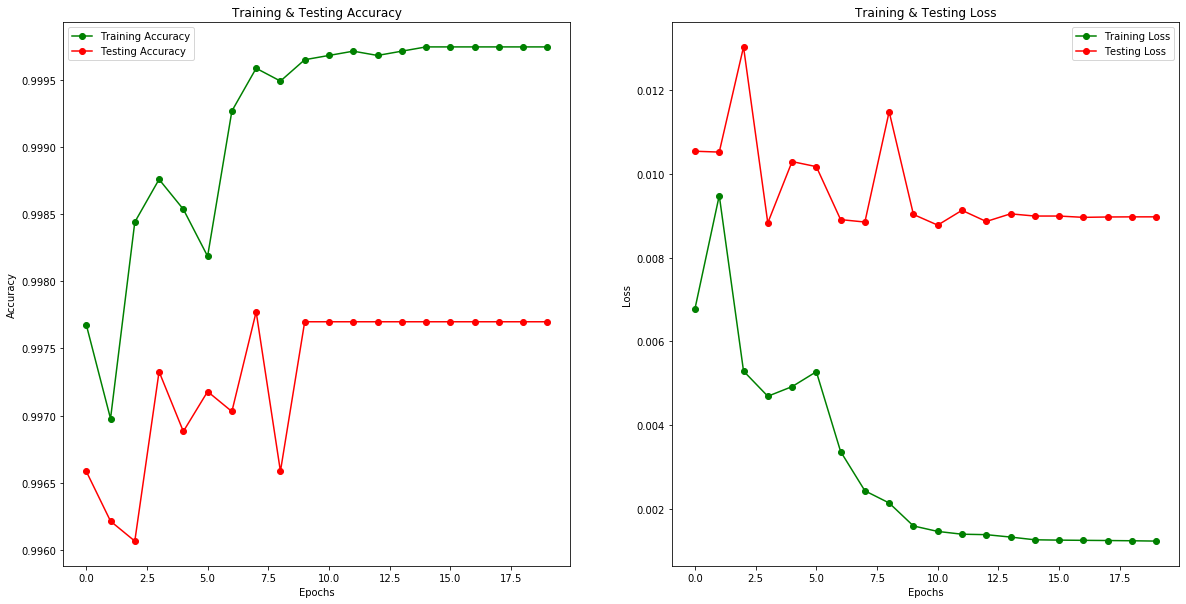

In [62]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = seq_model1.history['accuracy']
train_loss = seq_model1.history['loss']
val_acc = seq_model1.history['val_accuracy']
val_loss = seq_model1.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [63]:
train_lstm_results = lstm_model.evaluate(X_train_pad, y_train, verbose=0, batch_size=256)
test_lstm_results = lstm_model.evaluate(X_test_pad, y_test, verbose=0, batch_size=256)
print("Train accuracy: {}".format(train_lstm_results[1]*100))
print("Test accuracy: {}".format(test_lstm_results[1]*100))

Train accuracy: 99.97454285621643
Test accuracy: 99.76986050605774


In [66]:
y_pred = lstm_model.predict_classes(X_test_pad)
print("Accuarcy: {}".format(round(accuracy_score(y_test, y_pred)*100,2)))

Accuarcy: 99.77


In [67]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: \n", cm)

Confusion Matrix: 
 [[7049   20]
 [  11 6390]]


In [68]:
print("Classification Report: \n", classification_report(y_test, y_pred))

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7069
           1       1.00      1.00      1.00      6401

    accuracy                           1.00     13470
   macro avg       1.00      1.00      1.00     13470
weighted avg       1.00      1.00      1.00     13470



### GRU

In [69]:
emb_dim = embedding_matrix.shape[1]
gru_model = Sequential()
gru_model.add(Embedding(vocab_len, emb_dim, trainable = False, weights=[embedding_matrix]))
gru_model.add(GRU(128, return_sequences=False))
gru_model.add(Dropout(0.5))
gru_model.add(Dense(1, activation = 'sigmoid'))
gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(gru_model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               87936     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 1,088,065
Trainable params: 88,065
Non-trainable params: 1,000,000
_________________________________________________________________
None


In [70]:
%%time
seq_model2 = gru_model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=20, batch_size = 256, callbacks=([reduce_lr, early_stop]))

Train on 31428 samples, validate on 13470 samples
Epoch 1/20
31428/31428 [==============================] - 37s 1ms/step - loss: 0.2340 - accuracy: 0.9049 - val_loss: 0.2734 - val_accuracy: 0.9036
Epoch 2/20
31428/31428 [==============================] - 36s 1ms/step - loss: 0.1215 - accuracy: 0.9625 - val_loss: 0.0650 - val_accuracy: 0.9826
Epoch 3/20
31428/31428 [==============================] - 37s 1ms/step - loss: 0.0637 - accuracy: 0.9819 - val_loss: 0.0523 - val_accuracy: 0.9829
Epoch 4/20
31428/31428 [==============================] - 40s 1ms/step - loss: 0.0466 - accuracy: 0.9863 - val_loss: 0.0380 - val_accuracy: 0.9875
Epoch 5/20
31428/31428 [==============================] - 39s 1ms/step - loss: 0.0354 - accuracy: 0.9902 - val_loss: 0.0207 - val_accuracy: 0.9947
Epoch 6/20
31428/31428 [==============================] - 41s 1ms/step - loss: 0.0212 - accuracy: 0.9946 - val_loss: 0.0136 - val_accuracy: 0.9959
Epoch 7/20
31428/31428 [==============================] - 40s 1ms/st

### Evaluate Model

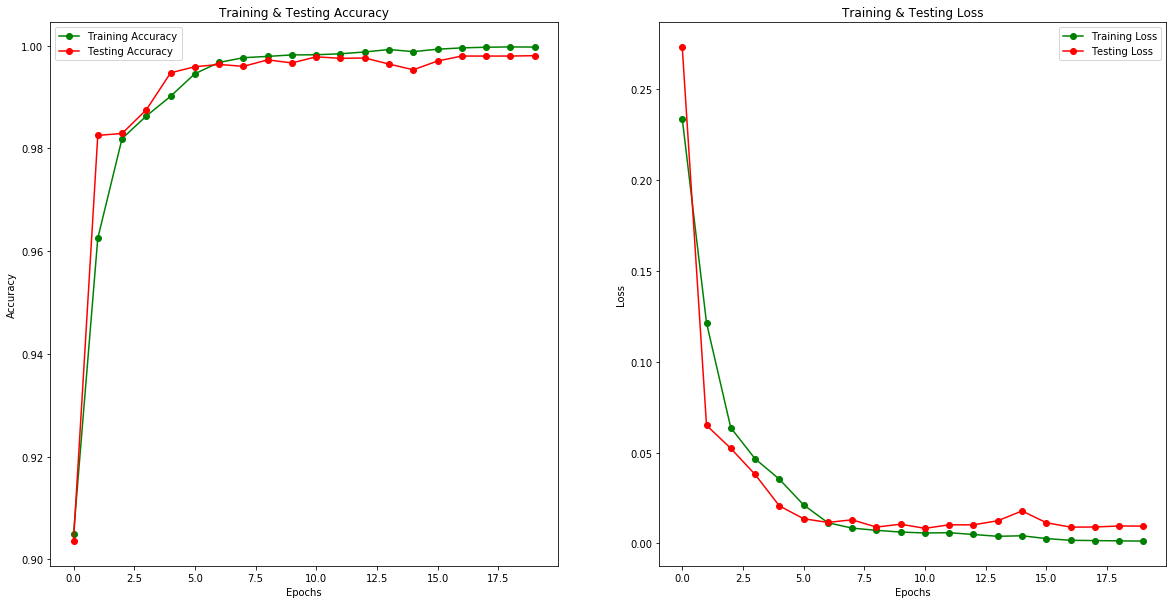

In [71]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = seq_model2.history['accuracy']
train_loss = seq_model2.history['loss']
val_acc = seq_model2.history['val_accuracy']
val_loss = seq_model2.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [72]:
train_gru_results = gru_model.evaluate(X_train_pad, y_train, verbose=0, batch_size=256)
test_gru_results = gru_model.evaluate(X_test_pad, y_test, verbose=0, batch_size=256)
print("Train accuracy: {}".format(train_gru_results[1]*100))
print("Test accuracy: {}".format(test_gru_results[1]*100))

Train accuracy: 99.97772574424744
Test accuracy: 99.80697631835938


In [73]:
y_pred = gru_model.predict_classes(X_test_pad)
print("Accuarcy: {}".format(round(accuracy_score(y_test, y_pred)*100,2)))

Accuarcy: 99.81


In [74]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: \n", cm)

Confusion Matrix: 
 [[7059   10]
 [  16 6385]]


In [76]:
print("Classification Report: \n", classification_report(y_test, y_pred))

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7069
           1       1.00      1.00      1.00      6401

    accuracy                           1.00     13470
   macro avg       1.00      1.00      1.00     13470
weighted avg       1.00      1.00      1.00     13470

